This lab on PCS and PLS is a python adaptation of p. 256-259 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Original adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

# 6.7.1 Principal Components Regression

Principal components regression (PCR) can be performed using the `PCA()`
function, which is part of the `sklearn` library. In this lab, we'll apply PCR to the `Hitters`
data, in order to predict `Salary`. As in previous labs, we'll start by ensuring that the missing values have
been removed from the data:

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation

df = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


/home/gperaza/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's set up our data:

In [5]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

Unfortunately `sklearn` does not have an implementation of PCA and regression combined like the `pls`, package in R: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data:

In [7]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

Let's print out the first few variables of the first few principal components:

In [8]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


Now we'll perform 10-fold cross-validation to see how it influences the MSE:

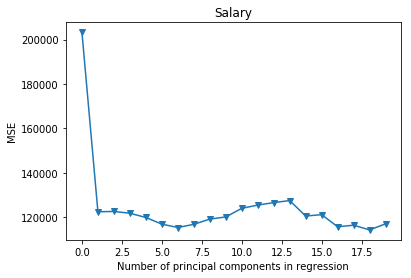

In [11]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We see that the smallest cross-validation error occurs when $M = 18$ components
are used. This is barely fewer than $M = 19$, which amounts to
simply performing least squares, because when all of the components are
used in PCR no dimension reduction occurs. However, from the plot we
also see that the cross-validation error is roughly the same when only one
component is included in the model. This suggests that a model that uses
just a small number of components might suffice.

We'll do a little math to get the amount of variance explained by adding each consecutive principal component:

In [12]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 38.31,  60.15,  70.84,  79.03,  84.29,  88.63,  92.26,  94.96,
        96.28,  97.25,  97.97,  98.64,  99.14,  99.46,  99.73,  99.88,
        99.95,  99.98,  99.99])

We'll dig deeper into this concept in Chapter 10, but for now we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. For example,
setting $M = 1$ only captures 38.31% of all the variance, or information, in
the predictors. In contrast, using $M = 6$ increases the value to 88.63%. If
we were to use all $M = p = 19$ components, this would increase to 100%.

Now let's perform PCA on the training data and evaluate its test set
performance:

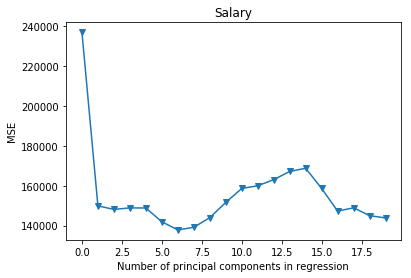

In [13]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We find that the lowest cross-validation error occurs when $M = 6$
components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [14]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111994.42273636987

This test set MSE is competitive with the results obtained using ridge regression
and the lasso. However, as a result of the way PCR is implemented,
the final model is more difficult to interpret because it does not perform
any kind of variable selection or even directly produce coefficient estimates.

# 6.7.2 Partial Least Squares

Scikit-learn `PLSRegression` gives same results as the `pls` package in R when using `method='oscorespls'`. However, the standard method used is `'kernelpls'`, which we'll use here. Feel free to try out both.

(-1, 19.899999999999999)

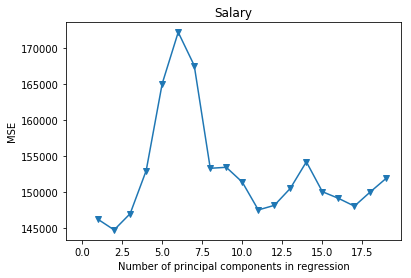

In [15]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_validation.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

The lowest cross-validation error occurs when only $M = 2$ partial least
squares dimensions are used. We now evaluate the corresponding test set
MSE:

In [16]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104711.20627773694

The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.